In [26]:
import pandas as pd
import math
import numpy as np
from scipy import stats
from scipy import optimize
import matplotlib.pyplot as plt
from google.colab import files
import matplotlib.mlab as mlab
import string


WIG_20 = np.array(["ACP","CDR","JSW","LTS","PEO","PKN","SPL","ALE","CPS","KGH","MRC","PGE","PKO","TPE","CCC","DNP","LPP","OPL","PGN","PZU"])
TRAINING_DATE_START = pd.to_datetime('2017-03-28')
TRAINING_DATE_END = pd.to_datetime('2018-03-27')
TODAY = pd.to_datetime('2018-03-28')
RISK_FREE_R = 0.03

Zakładamy, że dziś jest **2018-03-28**. 
- $S^1_t$ - wartość indeksu **WIG20**.
- $S^2_t$ - wartość **KGHM**.
Zakładamy, że dynamika cen zachowuje się następująco:
$$ \log \left(\frac{S^i_{t+1}}{S^i_{t}}\right) = \alpha_i N^i_t + \beta_i, $$ gdzie 
$\alpha_i, \beta_i \in \mathbb{R}$, $N^i_t \sim \mathcal{N}(0, 1)$ 
oraz
- $N^i_t, N^j_s$ są nzl dla $t \neq s$ oraz dowolnych $i, j$.
- $N^1_t, N^2_t$ mają stąłą korelację $\rho$.


Rozważane opcje:
- A - notowana na GPW opcja EC(K = 2200, T = grudzień 2018) o symbolu: **OW20L182200** dnia 2018-03-28 warta  [147,55 PLN](https://www.gpw.pl/archiwum-notowan?fetch=0&type=66&instrument=OW20L182200&date=28-03-2018&show_x=Poka%C5%BC+wyniki)
- B
- C
- D
- E

Standardy opcji na GPW
- [standard](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/Standard_opcje_WIG20_1.12.2019.pdf?fbclid=IwAR3dQYsMjxdt9OVWbk71_GaJYnhGbdAIBID11YPsod3HZc_UuLUrYyk2EcU)
- [KID opcje call](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/KID/KID_GPW_opcje_long_short_call_PL.pdf?fbclid=IwAR3zCcHiYmQaMaKQ0N7y-nxYcPTs7o0R-gcXQRf2Byt9Y9nmPtxOPHFkDpQ)
- [KID opcje put](https://www.gpw.pl/pub/GPW/files/PDF/standardy_pl/KID/KID_GPW_opcje_long_short_put_PL.pdf?fbclid=IwAR35-JtY7MFxmiuVtmnreBshRFDtC_vviUXGNVFys6oSRLcGqTNJ29f-pos)

Nazwa skrócona opcji **OXYZkrrcccc**

Gdzie:
- O – rodzaj instrumentu,
- XYZ – kod określający nazwę instrumentu bazowego 
- k – kod określający typ i miesiąc wygaśnięcia opcji
- rr – dwie ostatnie cyfry roku wygaśnięcia,
- cccc – kurs wykonania

Miesiąc	Kod opcji kupna	Kod opcji sprzedaży

In [27]:
pd.DataFrame(np.array([['styczeń', 'A', 'M'],['luty'	,'B'	,'N'],['marzec'	,'C'	,'O'],['kwiecień'	,'D'	,'P'],['maj'	,'E'	,'Q'],['czerwiec'	,'F'	,'R'],['lipiec'	,'G'	,'S'],['sierpień'	,'H'	,'T'],['wrzesień'	,'I'	,'U'],['październik'	,'J'	,'V'],['listopad'	,'K'	,'W'],['grudzień'	,'L'	,'X'],]), columns=['miesiąc', 'call', 'put'])

,miesiąc,call,put
0,styczeń,A,M
1,luty,B,N
2,marzec,C,O
3,kwiecień,D,P
4,maj,E,Q
5,czerwiec,F,R
6,lipiec,G,S
7,sierpień,H,T
8,wrzesień,I,U
9,październik,J,V


In [28]:
def ReadAndPreprocess(url, ticker):
    data = pd.read_csv(url)
    data['Data'] = pd.to_datetime(data['Data'])
    data['Zwroty_dzienne'] = data['Zamkniecie'].pct_change()
    # log (S_{t+1} / S_t)
    data['Log_ratio'] = np.log(data['Zamkniecie']/ data['Zamkniecie'].shift(1))
    data['Company'] = ticker
    return data
  

def ReadWig20DailyPrices(url_prefix = 'https://raw.githubusercontent.com/wfica/stochastic-fin-maths/main/notowania_wig_20/',):
  df = pd.DataFrame()
  for company in WIG_20:
    url = url_prefix + company[:3].lower() + '_d.csv'
    data = ReadAndPreprocess(url, company)
    df = df.append(data, ignore_index=True)
  data = ReadAndPreprocess(url_prefix +'wig20_d.csv', 'W20')
  df = df.append(data, ignore_index=True)
  return df


wig_20_all = ReadWig20DailyPrices()

In [29]:
wig_20_all

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Zwroty_dzienne,Log_ratio,Company
0,2015-06-02,43.613,43.750,43.361,43.361,301234.0,NaN,NaN,ACP
1,2015-06-03,43.470,44.190,43.002,43.002,379703.0,-0.008279,-0.008314,ACP
2,2015-06-05,42.315,42.698,41.098,41.133,161965.0,-0.043463,-0.044436,ACP
3,2015-06-08,41.494,42.423,41.278,42.207,237014.0,0.026110,0.025775,ACP
4,2015-06-09,42.207,42.885,41.485,42.244,136809.0,0.000877,0.000876,ACP
...,...,...,...,...,...,...,...,...,...
85127,2021-10-20,2447.070,2453.570,2432.330,2443.110,22261931.0,-0.001810,-0.001812,W20
85128,2021-10-21,2433.750,2433.750,2418.230,2427.350,18086091.0,-0.006451,-0.006472,W20
85129,2021-10-22,2425.020,2436.870,2412.570,2417.090,16121524.0,-0.004227,-0.004236,W20
85130,2021-10-25,2415.520,2430.620,2415.520,2427.190,16544470.0,0.004179,0.004170,W20


In [30]:
def ComputeModelParams(df=wig_20_all, start_date=TRAINING_DATE_START, end_date=TRAINING_DATE_END, tickers = np.append(WIG_20, 'W20')):
  stats = pd.DataFrame(columns=['Company', 'mean', 'std'])
  for i, ticker in enumerate(tickers):
    data = df[(df['Company'] == ticker) & (df['Data'] >= start_date) & (df['Data'] < end_date)]

    # Średnia i odchylenie standardowe
    mean = data['Zwroty_dzienne'].mean()
    std =  data['Zwroty_dzienne'].std()

    # Normujemy parametry
    trading_days = data.shape[0]
    mu = mean * trading_days
    sigma = std * math.sqrt(trading_days)
    
    stats.loc[i] = [ticker, mu, sigma]
  # stats = stats.set_index('Company')
  return stats

params = ComputeModelParams()

In [31]:
params

,Company,mean,std
0,ACP,-0.098013,0.237382
1,CDR,0.469464,0.372601
2,JSW,0.362118,0.365446
3,LTS,0.101120,0.350194
4,PEO,0.005175,0.209975
5,PKN,-0.071262,0.345428
6,SPL,0.106418,0.293260
7,ALE,NaN,NaN
8,CPS,0.060417,0.229678
9,KGH,-0.244517,0.303003


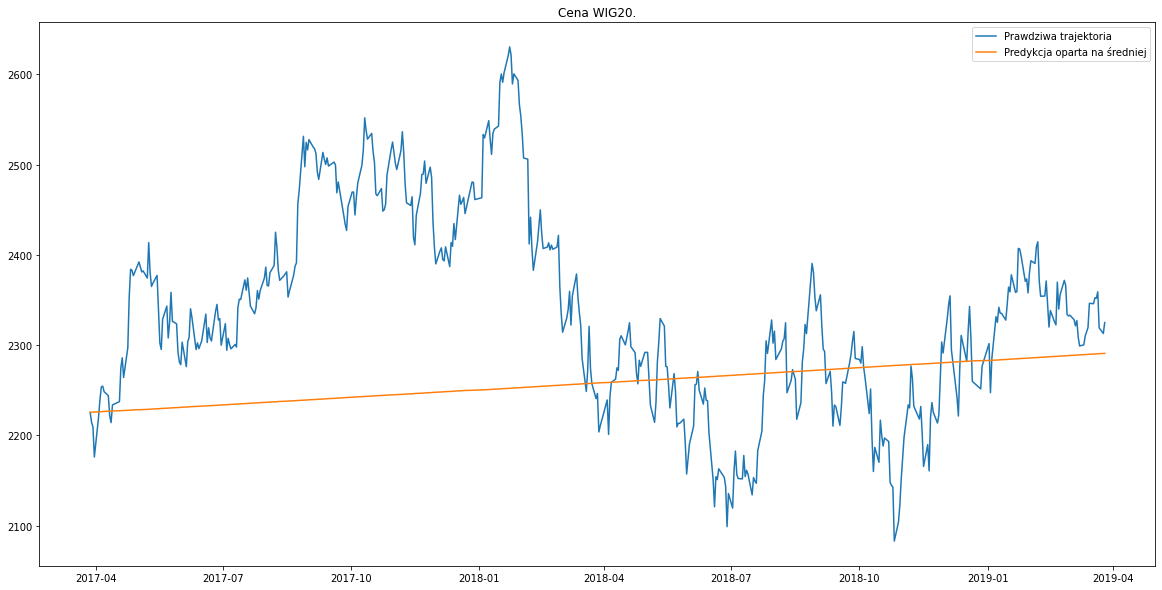

In [32]:
# Confirm that mu is reasonable.

def MuBasedPred(_trading_days, plot_start, ticker = 'W20'):
  # _trading_days = wig_20_plot['Data'].shape[0]
  _dt = 1./_trading_days
  init_price = wig_20_all[ (wig_20_all['Data'] == plot_start) & (wig_20_all['Company'] == ticker)]['Zamkniecie'].item()
  estimated_mu = params[params['Company'] == ticker]['mean'].item()

  simple_preds = np.full(_trading_days, init_price)
  for i in range(1, _trading_days):
    simple_preds[i] = simple_preds[i-1] * (1. + estimated_mu*_dt)
  return simple_preds 

plot_start = TRAINING_DATE_START
plot_end = TRAINING_DATE_END + pd.DateOffset(years=1)
wig_20_plot = wig_20_all.loc[(wig_20_all['Data'] >= plot_start) & (wig_20_all['Data'] < plot_end) & (wig_20_all['Company'] == 'W20') ]

plt.figure(figsize=(20,10))
plt.plot(wig_20_plot['Data'],wig_20_plot['Zamkniecie'] ,label='Prawdziwa trajektoria' )
plt.title('Cena WIG20.')

simple_preds = MuBasedPred( wig_20_plot['Data'].shape[0], plot_start)
plt.plot(wig_20_plot['Data'], simple_preds, label = 'Predykcja oparta na średniej')
plt.legend()
plt.show()
# plt.savefig('wig20_cena.png', bbox_inches = 'tight', pad_inches = 0.01)
# files.download('wig20_cena.png')

# Część I.2

Wzory matematyczne
$$
R_t^i = \log\left(\frac{S^i_{t+1}}{S^i_t}\right)\\
\mathbb{E} (\sum R^i) = n\beta_i\\
Var(R^i) = (\alpha^i)^2 \\
\rho = \frac{Cov(R^1, R^2)}{\sigma_{R^1}\sigma_{R^2}}
$$

In [33]:
def getBeta(df):
    return df['Zwroty_dzienne'].mean()

def getAlpha(df):
    return df['Zwroty_dzienne'].std()

def getRho(df1, df2):
    return np.corrcoef([df1['Zwroty_dzienne'], df2['Zwroty_dzienne']])

def getMathCalibration():
    kghm_daily_td = wig_20_all[(wig_20_all['Company'] == "KGH") & (wig_20_all['Data'] >= TRAINING_DATE_START ) & (wig_20_all['Data'] < TRAINING_DATE_END)]
    wig_20_daily_td = wig_20_all[(wig_20_all['Company'] == "W20") & (wig_20_all['Data'] >= TRAINING_DATE_START ) & (wig_20_all['Data'] < TRAINING_DATE_END)]
    kghm_alpha, kghm_beta = getAlpha(kghm_daily_td), getBeta(kghm_daily_td)
    wig20_alpha, wig20_beta = getAlpha(wig_20_daily_td), getBeta(wig_20_daily_td)
    rho = getRho(wig_20_daily_td, kghm_daily_td)
    return (kghm_alpha, kghm_beta, wig20_alpha, wig20_beta, rho)

kghm_alpha, kghm_beta, wig20_alpha, wig20_beta, rho = getMathCalibration()

print("KGHM alpha: ", kghm_alpha)
print("KGHM beta: ", kghm_beta)
print("WIG20 alpha:", wig20_alpha)
print("WIG20 beta:", wig20_beta)
print("rho: ", rho[0][1])

KGHM alpha:  0.01920206384079161
KGHM beta:  -0.0009819978069182424
WIG20 alpha: 0.009646251371667958
WIG20 beta: 0.00011643377445884814
rho:  0.5544543813596664


## Część I.3

Będziemy badać portfel składający się z opcji na indeks, indeksu i pieniędzy (inwestycji wolnej od ryzyka). Skorzystamy z formuły Blacka-Scholesa na cenę opcji call. Mamy:

$$V_{call}=SN(d_1)-Ee^{-r(T-t)}N(d_2),$$
gdzie $N(x)$ jest dystrybuantą rozkładu normalnego, $S$ to obecna cena indeksu, $E$ to strike rozważanej opcji, $r$ to stopa procentowa, $T$ to chwila wykonania, a $t$ to chwila obecna (wyrażane w latach). Dodatkowo,

$d_1=\frac{log(\frac{S}{E})+(r+\frac{\sigma^2}{2})(T-t)} {\sigma \sqrt{T-t}}$ oraz $d_2=d_1-\sigma(T-t)$.

Nie znamy dokładnej wartości $\sigma$, więc korzystamy z tego co wyliczyliśmy na początku na podstawie danych historycznych. Dzięki call-put parity, czyli równaniu $V_{call}+Ee^{-r(T-t)}=V_{put}+S$ wyliczymy cenę odpowiedniej opcji put. Korzystając z liczonych wczesniej trajektorii ceny indeksu, zbadamy rozkład zysku z naszego portfela dla różnych opcji w zależności od liczby rehedgingów. 

In [34]:
def d1(S,E,t,T,si,r):
  return (math.log(S/E)+(r+(si*si)/2)*(T-t)/250)/(si*math.sqrt((T-t)/250))

def d2(S,E,t,T,si,r):
  return d1(S,E,t,T,si,r)-si*(T-t)/250

# ceny opcji w chwili t, gdy cena jest S
def vcall(S,E,t,T,si,r):
  V = S*stats.norm.cdf(d1(S,E,t,T,si,r))-E*math.exp(-r*(T-t)/250)*stats.norm.cdf(d2(S,E,t,T,si,r))
  return V

def vput(S,E,t,T,si,r):
  return vcall(S,E,t,T,si,r)+E*math.exp(-r*(T-t)/250)-S

# delta do zabezpieczenia opcji
def delta_call(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))

def delta_put(S,E,t,T,si,r):
  return stats.norm.cdf(d1(S,E,t,T,si,r))-1



def call_payoff(price_at_exp, strike):
  return max(0., price_at_exp-strike)

def put_payoff(price_at_exp, strike):
  return max(0., strike - price_at_exp)



In [35]:
wig20_today_price = wig_20_all[ (wig_20_all['Data'] == TODAY) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].item()
wig20_sigma = params[params['Company'] == 'W20']['std'].item()

In [36]:
wig20_today_bs_price = vcall(wig20_today_price,2200,0,int(0.75*250),wig20_sigma,RISK_FREE_R)
print('Cena BS {} PLN.'.format(wig20_today_bs_price))
print('Cena na GPW  147,55 PLN.')


Cena BS 127.29884002335302 PLN.
Cena na GPW  147,55 PLN.


# Cześć I.4


In [37]:
FUTURE = pd.to_datetime('2018-10-01')
wig20_to_october_prices = wig_20_all[(wig_20_all['Data'] <= FUTURE) & (wig_20_all['Data'] >= TODAY) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].to_numpy()
# Number of days from future till option expiry date3
wig_20_all[(wig_20_all['Data'] <= pd.to_datetime('2018-12-21')) & (wig_20_all['Data'] >= pd.to_datetime('2018-10-01')) & (wig_20_all['Company'] == 'W20')].shape[0]

58

In [38]:
# Na dzień 2018-10-01
wig20_future_bs_price = vcall(wig20_to_october_prices[-1], 2200, 0, 58, wig20_sigma, RISK_FREE_R)
print("Cena BS {} PLN".format(wig20_future_bs_price))
print('Cena na GPW 153.00 PLN')

Cena BS 98.75542683755384 PLN
Cena na GPW 153.00 PLN


In [39]:
kghm_future_price = wig_20_all[(wig_20_all['Data'] == FUTURE) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].item()
kghm_today_price = wig_20_all[(wig_20_all['Data'] == TODAY) & (wig_20_all['Company'] == 'KGH')]['Zamkniecie'].item()

In [40]:
def optionA(prices): 
    return max(0, prices[-1]-2200)

# up-and-out
def optionB(prices):
    return max(0, prices[-1] - 2200) if max(prices) < 2400 else 0

# up-and-in
def optionC(prices):
    return max(0, prices[-1] - 2200) if max(prices) >= 2400 else 0

def optionD(prices):
    counter = 0
    optionExec = False
    for p in prices:
        if p > 2400:
            counter += 1
        else:
            counter = 0
        if counter == 10:
            optionExec = True
    if optionExec:
        return max(0, prices[-1] - 2200)
    return 0

def calculateBinaryCondition(today_price, future_price):
    return future_price > today_price

def optionE(prices, binaryCondition): 
    if binaryCondition:
        return prices[-1] - min(prices)
    return 0

In [41]:
print("Wyplata opcji A: ", optionA(wig20_to_october_prices))
print("Wyplata opcji B: ", optionB(wig20_to_october_prices))
print("Wyplata opcji C: ", optionC(wig20_to_october_prices))
print("Wyplata opcji D: ", optionD(wig20_to_october_prices))
print("Wyplata opcji E: ", optionE(wig20_to_october_prices, calculateBinaryCondition(kghm_today_price, kghm_future_price)))

Wyplata opcji A:  84.01000000000022
Wyplata opcji B:  84.01000000000022
Wyplata opcji C:  0
Wyplata opcji D:  0
Wyplata opcji E:  185.26000000000022


# Część II.

### Założenia.

Przypomnijmy, mamy dwa procesy stochastyczne
- $S^1_t$ - wartość indeksu **WIG20**.
- $S^2_t$ - wartość **KGHM**.

Oraz instrument wolny od ryzyka 
- $S^0_t = e^{rt}$


Zakładamy, że dynamika cen zachowuje się następująco:
$$ \log \left(\frac{S^i_{t+1}}{S^i_{t}}\right) = \alpha_i N^i_t + \beta_i, $$ gdzie 
$\alpha_i, \beta_i \in \mathbb{R}$, oraz w mierze $\mathbf{P}$ zmienne $N^i_t$ mają rozkłąd normalny, tj. $N^i_t \sim_\mathbf{P} \mathcal{N}(0, 1)$ 
oraz
- $N^i_t, N^j_s$ są nzl dla $t \neq s$ oraz dowolnych $i, j$.
- $N^1_t, N^2_t$ mają stąłą korelację $\rho$.


### Wycena.
Do wyceny instrumentów potrzebujemy znaleźć równoważną miarę martyngałową $\mathbf{Q}$, tj.
- $\mathbf{Q} \ll \mathbf{P} $ i $ \mathbf{P} \ll \mathbf{Q}$
- Zdyskontowane procesy cen $ \frac{S^i_t}{S^0_t}$ są $\mathbf{Q}$-martyngałami.

Chcemy aby
\begin{align}
\mathbb{E}_\mathbf{Q}\left[\frac{S^i_{t+1}}{S^0_{t+1}} | F_t\right] = \frac{S^i_t}{S^0_t},
\end{align}
dla każdego $t$.

Rozpisujemy,
\begin{align}
\mathbb{E}_\mathbf{Q}\left[\frac{S^i_{t+1}}{S^0_{t+1}} | F_t\right] 
=&  \mathbb{E}_\mathbf{Q}\left[\frac{S^i_{t+1}}{S^0_{t}e^r} | F_t\right]  \\ 
=& \mathbb{E}_\mathbf{Q}\left[\frac{S^i_{t}e^{\alpha_i N^i_t + \beta_i}}{S^0_{t}e^r} | F_t\right] \\ 
=& \frac{S^i_t}{S^0_{t}e^r} \mathbb{E}_\mathbf{Q}\left[e^{\alpha_i N^i_t + \beta_i} | F_t\right] \\ 
=& \frac{S^i_t}{S^0_{t}e^r} \mathbb{E}_\mathbf{Q}\left[e^{\alpha_i N^i_t + \beta_i} \right] \\
\end{align}

Zatem chcemy aby
\begin{align}
\mathbb{E}_\mathbf{Q}\left[e^{\alpha_i N^i_t + \beta_i} \right] = e^r
\end{align}

Miarę $\mathbf{Q}$ można wyspecyfikować za pomocą pochodnej Radona-Nikodyma $\frac{d\mathbf{Q}}{d\mathbf{P}}$. Wtedy powyższy warunek przepisuje się na 

\begin{align}
\mathbb{E}_\mathbf{P}\left[e^{\alpha_i N^i_t + \beta_i} \frac{d\mathbf{Q}}{d\mathbf{P}} \right] = e^r
\end{align}

Przyjmując $\frac{d\mathbf{Q}}{d\mathbf{P}} = e^K$  dla pewnej zmiennej losowej $K$ mamy warunek

\begin{align}
\mathbb{E}_\mathbf{P}\left[e^{\alpha_i N^i_t + K}  \right] = e^{r-\beta_i}.
\end{align}

Pozostaje zatem znaleźć zmienną $K$ taką, że (*)
- $\mathbb{E}_\mathbf{P}\left[e^{K}  \right]  = 1$
- $\mathbb{E}_\mathbf{P}\left[e^{\alpha_1 N^1_t + K}  \right] = e^{r-\beta_1}.$
- $\mathbb{E}_\mathbf{P}\left[e^{\alpha_2 N^2_t + K}  \right] = e^{r-\beta_2}.$


Będziemy szukać zmiennej  $K$ pośród zmiennych o rozkładznie normalnym w mierze $\mathbf{P}$. Aby móc policzyć odpowiedznie wartości oczekiwane chcemy znać zależności między $N^i_t$ a $K$. Przyjmijmy, że (**)

\begin{align}
\begin{pmatrix}
N^1_t \\N^2_t \\K \\
\end{pmatrix} \sim_\mathbf{P} \mathcal{N}\left( \begin{pmatrix}
0 \\0 \\ \mu \\
\end{pmatrix}, \begin{pmatrix}
1& \rho& a \\\rho& 1& b \\ a& b& 1 \\
\end{pmatrix}  \right)
\end{align}
z nadzieją, że uda się dobrać parametry $\mu, a, b$ tak aby spełone były żądane równania.

Zauważmy, że wtedy 
- $\alpha_1 N^1_t + K \sim_\mathbf{P} \mathcal{N}(\mu,\alpha_1^2 + 2a\alpha_1 +1) $
- $\alpha_2 N^2_t + K \sim_\mathbf{P} \mathcal{N}(\mu,\alpha_2^2 + 2b\alpha_2 +1) $

#### Lemat 
Dla $Z \sim \mathcal{N}(\mu, \sigma^2)$ zachodzi 
$$
  \mathbb{E}[e^Z] = e^{\mu + \frac{\sigma^2}{2}}.
$$

Korzystając z lematu przepisujemy warunki (*).
- $1 = \mathbb{E}_\mathbf{P}\left[e^{K}  \right] = e^{\mu + \frac{1}{2}}$. Zatem $\mu = -\frac{1}{2}.$
- $  e^{r-\beta_1} = \mathbb{E}_\mathbf{P}\left[e^{\alpha_1 N^1_t + K}  \right] = e ^ {\mu + \tfrac{\alpha_1^2 + 2a\alpha_1 +1}{2}}.$ 

Zatem 
\begin{align}
r-\beta_1 =  \mu + \frac{\alpha_1^2 + 2a\alpha_1 +1}{2} = \frac{\alpha_1^2 + 2a\alpha_1 }{2}.
\end{align}

Ostatecznie 
\begin{align}
a = \frac{r-\beta_1}{\alpha_1} - \frac{\alpha_1}{2}.
\end{align}

Podobnie wyliczamy
\begin{align}
b = \frac{r-\beta_2}{\alpha_2} - \frac{\alpha_2}{2}.
\end{align}









**Uwaga**: Własność (**) musi zachodzić dla wszystkich $t$.


In [137]:
NUM_TRADING_DAYS = 250.0

ALPHA_1 = params[params['Company'] == 'W20']['std'].item() / np.sqrt(NUM_TRADING_DAYS)
BETA_1 = params[params['Company'] == 'W20']['mean'].item() / NUM_TRADING_DAYS
ALPHA_2 = params[params['Company'] == 'KGH']['std'].item() / np.sqrt(NUM_TRADING_DAYS)
BETA_2 = params[params['Company'] == 'KGH']['mean'].item() / NUM_TRADING_DAYS
RATE = RISK_FREE_R / NUM_TRADING_DAYS # risk free rate divided by number of trading days

print(ALPHA_1, BETA_1)
print(ALPHA_2, BETA_2)

CONST_MU = -0.5
CONST_RHO = 0.5544543813596664
CONST_A = (RATE - BETA_1) / ALPHA_1 - ALPHA_1 / 2. 
CONST_B = (RATE - BETA_2) / ALPHA_2 - ALPHA_2 / 2. 

CONST_MU, CONST_RHO, CONST_A, CONST_B 

0.00962693953774014 0.00011596803936101274
0.019163621231981526 -0.0009780698156905694


(-0.50, 0.55, -0.00, 0.05)

In [151]:
def RandomTrajectory(W20_0, KGH_0, c_mu=  CONST_MU, c_rho = CONST_RHO, c_a = CONST_A, c_b = CONST_B, num_trading_days = NUM_TRADING_DAYS):
  """ Returns a pair. 
        first element = a realization of the random trajectory 
        second element = a realization of dQ/dP
      according to equaiton (**).
  """
  n_ = 2*int(num_trading_days)+1
  cov = np.identity(n_)
  for i in range(0,n_-1,2):
    cov[i][i+1] = c_rho
    cov[i+1][i] = c_rho
  for i in range(0, n_-1,2):
    cov[-1][i] = c_a 
    cov[-1][i+1] = c_b 
    cov.T[-1][i] = c_a 
    cov.T[-1][i+1] = c_b
  
  means = np.zeros(n_)
  means[-1] = c_mu 

  trajectory = np.zeros((int(num_trading_days), 2))
  trajectory[0][0] = W20_0
  trajectory[0][1] = KGH_0

  random_sample = np.random.multivariate_normal(means, cov)

  for i in range(1, int(num_trading_days)):
      # print(random_sample[i], ALPHA_1 * random_sample[i] + BETA_1)
      trajectory[i][0] = trajectory[i-1][0] * np.exp(ALPHA_1 * random_sample[i] + BETA_1)
      trajectory[i][1] = trajectory[i-1][1] * np.exp(ALPHA_2 * random_sample[i+1] + BETA_2)

  return trajectory, np.exp(random_sample[-1])


In [152]:
W20_0 = wig_20_all[(wig_20_all['Data'] == TRAINING_DATE_START) & (wig_20_all['Company'] == 'W20') ]['Zamkniecie'].item()
KGH_0 = wig_20_all[(wig_20_all['Data'] == TRAINING_DATE_START) & (wig_20_all['Company'] == 'KGH') ]['Zamkniecie'].item()


In [153]:
%precision 2
RandomTrajectory(W20_0, KGH_0)
0

0

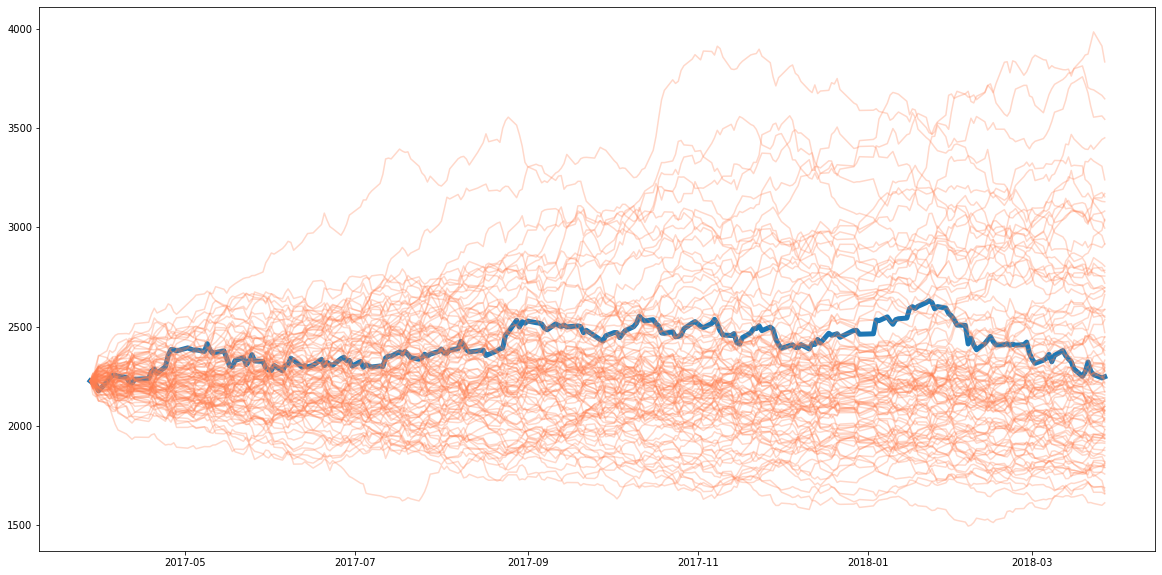

In [156]:
x= wig_20_all[(wig_20_all['Company'] == 'W20') & (wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] <= TRAINING_DATE_END) ]['Data']
true_prices = wig_20_all[(wig_20_all['Company'] == 'W20') & (wig_20_all['Data'] >= TRAINING_DATE_START) & (wig_20_all['Data'] <= TRAINING_DATE_END) ]['Zamkniecie']
assert x.shape[0] == NUM_TRADING_DAYS
plt.figure(figsize=(20,10))
plt.plot(x, true_prices, label = 'Historyczna trajektoria', linewidth=5)
for i in range(0, 100):
  predictions = RandomTrajectory(W20_0, KGH_0)[0][:, 0]
  plt.plot(x, predictions, color = 'coral', alpha=0.3)

# PLAYGROUND 

In [75]:

a = 2
b = 1
base = np.array([a, b]) 
copies = np.tile(base, int(NUM_TRADING_DAYS))
cov_last_row = np.concatenate((copies, np.array([1])))
cov = np.identity(2*int(NUM_TRADING_DAYS)+1)
cov[-1:] = cov_last_row
cov.T[-1:] = cov_last_row
print(cov)
means = np.zeros(2*int(NUM_TRADING_DAYS)+1)
means[-1] = -0.5
print(means)

[[1. 0. 0. ... 0. 0. 2.]
 [0. 1. 0. ... 0. 0. 1.]
 [0. 0. 1. ... 0. 0. 2.]
 ...
 [0. 0. 0. ... 1. 0. 2.]
 [0. 0. 0. ... 0. 1. 1.]
 [2. 1. 2. ... 2. 1. 1.]]
[ 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.

In [77]:
np.random.multivariate_normal(means, cov)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: covariance is not positive-semidefinite.
  """Entry point for launching an IPython kernel.


array([ 3.75481180e-01,  6.59922169e-01,  1.10081240e+00,  5.43781474e-02,
       -2.42465912e-01, -1.53053334e-01,  9.56666817e-01, -1.49967829e+00,
        5.18434352e-01,  1.18882112e-01, -6.37775538e-03,  8.36131503e-02,
        1.33433089e+00, -1.02282277e+00,  1.51428100e+00,  1.48908914e+00,
       -4.63504951e-01, -2.61390392e+00,  9.26043310e-01,  8.09386676e-01,
        7.31367362e-01,  4.00220620e-01,  6.93073342e-01, -3.55611906e-01,
        1.95085601e+00, -9.22719362e-01, -2.23327503e+00,  1.25284925e+00,
        1.15405037e+00,  1.86907719e+00,  3.35111736e-01,  1.78900282e-01,
        1.63650709e+00, -3.07651555e-01, -5.97172591e-02,  9.81430140e-02,
        8.99725622e-01,  4.48979725e-02, -3.50576093e-02,  1.95934452e-01,
       -2.07193390e-01,  1.41761997e-01,  1.23841023e+00,  1.71409385e+00,
       -1.48633648e+00,  2.26790915e-01, -1.88130124e+00,  2.58222381e-01,
       -1.27298634e-01,  1.88137186e+00,  6.86153949e-01, -9.52781876e-01,
        1.44286618e-01,  

In [ ]:
# !pip install swig
# !pip install vollib

ERROR: Could not find a version that satisfies the requirement swig (from versions: none)
ERROR: No matching distribution found for swig
  Using cached vollib-0.1.5-py3-none-any.whl
  Using cached lets_be_rational-1.0.9.tar.gz (51 kB)
  ERROR: Failed building wheel for lets-be-rational
  Running setup.py clean for lets-be-rational
Failed to build lets-be-rational
    Running setup.py install for lets-be-rational ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-n0h8p20z/lets-be-rational_633332f8c12d43f0a191b2ee9b1f6c8e/setup.py'"'"'; __file__='"'"'/tmp/pip-install-n0h8p20z/lets-be-rational_633332f8c12d43f0a191b2ee9b1f6c8e/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'e

In [ ]:
# import vollib.black_scholes as black_scholes

ModuleNotFoundError: ignored

In [ ]:
_trading_days = wig_20_plot['Data'].shape[0]
_dt = 1./_trading_days
wig20_init_price = wig_20_all[ (wig_20_all['Data'] == plot_start) & (wig_20_all['Company'] == 'W20')]['Zamkniecie'].item()
wig20_estimated_mu = params[params['Company'] == 'W20']['mean'].item()

In [ ]:
simple_preds = np.full(_trading_days, wig20_init_price)
for i in range(1, _trading_days):
  simple_preds[i] = simple_preds[i-1] * (1. + wig20_estimated_mu*_dt)
simple_preds = MuBasedPred( wig_20_plot['Data'].shape[0])


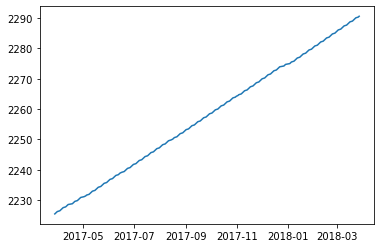

In [ ]:
plt.plot(wig_20_plot['Data'], simple_preds)

(array([ 1.,  0.,  0.,  0.,  1.,  1.,  2.,  5.,  4.,  1.,  6.,  5., 16.,
        13., 21., 27., 21., 35., 22., 16., 15., 14.,  7.,  5.,  3.,  4.,
         2.,  2.,  0.,  2.]),
 array([-0.04533611, -0.04262867, -0.03992123, -0.03721379, -0.03450635,
        -0.03179892, -0.02909148, -0.02638404, -0.0236766 , -0.02096916,
        -0.01826172, -0.01555428, -0.01284684, -0.0101394 , -0.00743196,
        -0.00472453, -0.00201709,  0.00069035,  0.00339779,  0.00610523,
         0.00881267,  0.01152011,  0.01422755,  0.01693499,  0.01964242,
         0.02234986,  0.0250573 ,  0.02776474,  0.03047218,  0.03317962,
         0.03588706]),
 <a list of 30 Patch objects>)

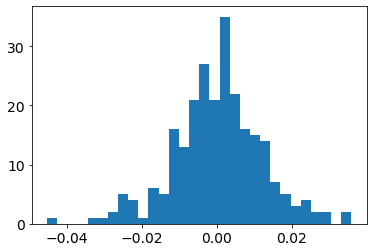

In [ ]:
||plt.hist(wig_20_daily_td['Returns'].values.flatten(), bins=30)
# wig_20_daily_td['Returns'].values.flatten().shape